In [1]:
from pathlib import Path
import pandas as pd
pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this
pd.options.mode.copy_on_write = True        # TESTING THIS...

In [2]:
!ls -ahl ~/exp_builds/astera.exp/rundata/run1/0.sprites

total 8.3M
drwxrwxr-x  3 cls0027 cls0027 4.0K Sep  4 19:20 .
drwxrwxr-x 11 cls0027 cls0027 4.0K Mar  3  2024 ..
lrwxrwxrwx  1 cls0027 cls0027   66 Mar  3  2024 0.sprites -> /home/cls0027/exp_builds/astera.exp/rundata/run1/0.sprites/sprites
lrwxrwxrwx  1 cls0027 cls0027   72 Mar  3  2024 0.sprites.debug -> /home/cls0027/exp_builds/astera.exp/rundata/run1/0.sprites/sprites.debug
-rw-rw-r--  1 cls0027 cls0027 1.2M Sep  4 19:19 0.sprites.debug.sdb
-rw-rw-r--  1 cls0027 cls0027  64K Sep  4 19:11 0.sprites.sdb
drwxrwxr-x  4 cls0027 cls0027 4.0K Sep  4 19:19 ast_dumps
-rw-rw-r--  1 cls0027 cls0027 655K Sep  4 19:28 function_params.csv
-rw-rw-r--  1 cls0027 cls0027 416K Sep  4 19:28 functions.csv
-rw-rw-r--  1 cls0027 cls0027   95 Sep  4 19:19 ghidra_ast.debug.json
-rw-rw-r--  1 cls0027 cls0027   98 Sep  4 19:11 ghidra_ast.json
-rw-rw-r--  1 cls0027 cls0027 1.3M Sep  4 19:28 locals.csv
-rw-rw-r--  1 cls0027 cls0027 741K Sep  4 19:28 _raw_debug_locals.csv
-rw-rw-r--  1 cls0027 cls0027 264K Sep 

In [3]:
from astlib import StructDatabase
from varlib.datatype import *

bin_folder = Path('/home/cls0027/exp_builds/astera.exp/rundata/run1/0.sprites')
#bin_folder/'_raw_debug_locals.csv'

funcs_df = pd.read_csv(bin_folder/'functions.csv')
locals_df = pd.read_csv(bin_folder/'locals.csv')
sdb = StructDatabase.from_json(bin_folder/'0.sprites.debug.sdb')

# drop COMP variables
locals_df = locals_df.dropna(subset='TypeJson_Debug')
locals_df['Type_Debug'] = locals_df.TypeJson_Debug.apply(DataType.from_json)

In [4]:
sid = sdb.sids_by_name['r_camera'][0]
sdb.structs_by_id[sid]

struct r_camera {
	0x0: float[3] position
	0xc: float[2] size
	0x14: float rotation
	0x18: float[4][4] view
	0x58: float[4][4] projection
	0x98: float near
	0x9c: float far
}

TypeSeq_Debug
ARR,STRUCT         0.697674
PTR,PTR,STRUCT     2.325581
PTR,STRUCT        84.883721
STRUCT            12.093023
Name: FunctionStart, dtype: float64

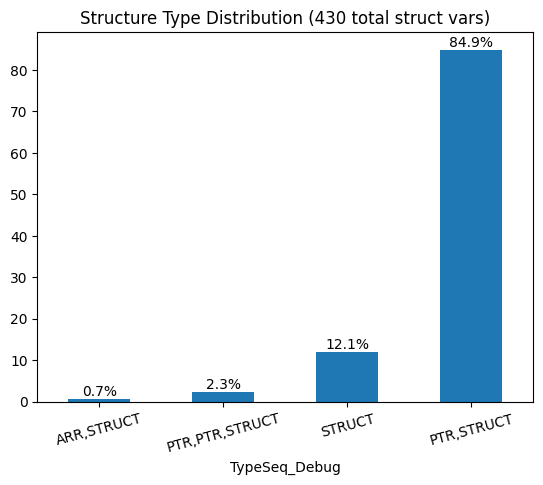

In [5]:
struct_vars = locals_df[locals_df.LeafCategory=='STRUCT']
ax = (struct_vars.groupby('TypeSeq_Debug').count().FunctionStart/len(struct_vars)*100).sort_values().plot(kind='bar',rot=15,
    title=f'Structure Type Distribution ({len(struct_vars):,} total struct vars)'
)

ax.bar_label(ax.containers[0], fmt='{:.1f}%')
struct_vars.groupby('TypeSeq_Debug').count().FunctionStart/len(struct_vars)*100

# Recover Offsets for PTR,STRUCT Variables
Try recovering STRUCT* offsets:

1. Retype variable to `char*`
2. Collect member offsets for this variable from AST (don't forget about implicit 0 offset)
3. Compare with truth (flattened structure layout)


In [6]:
struct_ptrs = struct_vars[struct_vars.TypeSeq_Debug=='PTR,STRUCT']
ghidra_acc = (struct_ptrs.TypeSeq_Strip==struct_ptrs.TypeSeq_Debug).sum()/len(struct_ptrs)*100
print(f'BTW - Ghidra accuracy on STRUCT* types: {ghidra_acc:.2f}%')

BTW - Ghidra accuracy on STRUCT* types: 6.85%


In [7]:
func_addr = struct_ptrs.iloc[0].FunctionStart
struct_ptrs[struct_ptrs.FunctionStart==func_addr].Signature.tolist()

['27,64,89', '43,56,101']

In [8]:
func_ptrs = struct_ptrs.groupby('FunctionStart').pipe(lambda gb: [df for func_addr, df in gb])[0]
func_ptrs

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,TypeJson_Debug,LeafCategory,LeafSigned,LeafFloating,LeafSize,PtrLevels,PtrL1,PtrL2,PtrL3,BinaryId
3,1084377,"27,64,89",lVar2,int64,register,rax,0,BUILTIN,int64,asset,...,"{""kind"": ""Pointe...",STRUCT,False,False,0,PLL,P,L,L,0
4,1084377,"43,56,101",lVar3,int64,register,rax,0,BUILTIN,int64,asset_00,...,"{""kind"": ""Pointe...",STRUCT,False,False,0,PLL,P,L,L,0


In [9]:
import pyhidra; pyhidra.start()
from ghidralib.decompiler import AstDecompiler
from ghidralib.ghidraretyper import GhidraRetyper
from ghidralib.projects import *

#with OpenSharedGhidraProject('localhost', 'astera') as proj:
osgp = OpenSharedGhidraProject('localhost', 'astera')
proj = osgp.__enter__()

sprites_strip = locate_binaries_from_project(proj, ['sprites'], strip_only=True)[0]
verify_ghidra_revision(sprites_strip, 1, rollback_delete=True)

#with GhidraCheckoutProgram(proj, sprites_strip) as co:
gcp = GhidraCheckoutProgram(proj, sprites_strip)
co = gcp.__enter__()

In [23]:
from astlib import FindAllVarRefs, VisitAllChildrenByDefaultVisitor, build_var_ast_signature
from astlib.ast import *
from ghidralib.decompiler import AstDecompiler
from ghidralib.ghidraretyper import GhidraRetyper
from ghidralib.projects import *
from typing import Set

def recover_structptr_member_offsets(co:GhidraCheckoutProgram, func_addr:int, sptr_signatures:List[str]) -> Dict[str, Set[int]]:
    '''
    Recover member offsets for the given variables in the given function, assuming it is a STRUCT* type.

    This function will retype the variables to char* to normalize the byte offsets.

    Returns a dictionary mapping variable signature -> list of recovered member offsets
    '''
    retyper = GhidraRetyper(co.program, sdb=None)
    pchar_t = PointerType(BuiltinType.from_standard_name('char'), 8)

    func = [f for f in co.decompiler.functions if f.entryPoint.offset == func_addr][0]

    ast, vars_by_sig = co.decompiler.decompile_and_extract_signatures(func)

    # set each structptr var to char*
    for sig in sptr_signatures:
        v = vars_by_sig[sig]
        high_sym = co.decompiler.local_sym_dict[v.name]
        retyper.set_funcvar_type(high_sym, pchar_t)

    # rerun decompiler
    ast, vars_by_sig = co.decompiler.decompile_and_extract_signatures(func)

    recovered_offsets = {}

    # collect offsets
    for sig in sptr_signatures:
        v = vars_by_sig[sig]
        refs = FindAllVarRefs(v.name).visit(ast)

        # basic pattern matching attempt
        # ------------------------------
        # simply looking for BinOp(+)->REF
        # since we know REF has been retyped to a char*, this should
        # only indicate a BYTE offset
        # (not a 2B, 4B, etc. offset b/c ptr arithmetic)

        candidates = []
        for x in refs:
            x:ASTNode
            if isinstance(x.parent, BinaryOperator):
                binop = x.parent
                if binop.opcode == '+':
                    candidates.append(binop)

        recovered_literals = [x for cand in candidates for x in cand.inner if isinstance(x, IntegerLiteral)]

        for x in recovered_literals:
            print(f'Recovered offset 0x{x.value:x} @ 0x{x.instr_addr:x}')

        # NOTE: we can return the list of IntegerLiterals if we need to see where we got offsets from
        recovered_offsets[sig] = set([lit.value for lit in recovered_literals])

    return recovered_offsets

var_offsets = recover_structptr_member_offsets(co, func_ptrs.iloc[0].FunctionStart, func_ptrs.Signature.to_list())
var_offsets

# TODO: always add offset 0 to the recovered offsets (it will always be implicit)
# TODO: show truth_offsets next to recovered...
# TODO: define a local struct definition with these offsets?

Recovered offset 0x8 @ 0x108c19
Recovered offset 0x8 @ 0x108c11


{'27,64,89': {8}, '43,56,101': {8}}

In [31]:
#func_ptrs.iloc[0].Type_Debug.leaf_type._db = sdb
func_ptrs.iloc[0].Type_Debug.leaf_type

struct asset_t {
	0x0: uint32 uid
	0x8: uchar* data
	0x10: uint32 data_length
	0x18: char* name
	0x20: int32 chunk_start
	0x24: int32 chunk_length
	0x28: uchar fs
	0x29: uchar filled
	0x2a: uchar req
	0x2b: uchar req_free
	0x2c: uchar chunk
}

In [32]:
gcp.__exit__(None, None, None)
osgp.__exit__(None, None, None)

PROGRAM CHANGED - CHECKING IN


In [7]:
var_row = struct_ptrs.iloc[0]

stype = var_row.Type_Debug.leaf_type
print(stype._db)
stype._db = sdb     # set sdb so stype can find definition
stype_flat =stype.flatten()
stype_flat

None


struct asset_t:FLAT {
	0x0: uint32 uid
	0x8: uchar* data
	0x10: uint32 data_length
	0x18: char* name
	0x20: int32 chunk_start
	0x24: int32 chunk_length
	0x28: uchar fs
	0x29: uchar filled
	0x2a: uchar req
	0x2b: uchar req_free
	0x2c: uchar chunk
}

In [8]:
sdb.find_nested_structures()[25]

struct _GLFWcursor {
	0x0: _GLFWcursor* next
	0x8: _GLFWcursorX11 x11
}

In [9]:
truth_offsets = list(stype.flatten().layout.keys())
truth_offsets

[0, 8, 16, 24, 32, 36, 40, 41, 42, 43, 44]

In [10]:
var_row

FunctionStart                     1084377
Signature                        27,64,89
Name_Strip                          lVar2
Type_Strip                          int64
LocType_Strip                    register
LocRegName_Strip                      rax
LocOffset_Strip                         0
TypeCategory_Strip                BUILTIN
TypeSeq_Strip                       int64
Name_Debug                          asset
Type_Debug                       asset_t*
LocType_Debug                    register
LocRegName_Debug                      rax
LocOffset_Debug                       0.0
TypeCategory_Debug                    PTR
TypeSeq_Debug                  PTR,STRUCT
HasDWARF                            False
TypeJson_Debug        {"kind": "Pointe...
LeafCategory                       STRUCT
LeafSigned                          False
LeafFloating                        False
LeafSize                                0
PtrLevels                             PLL
PtrL1                             

In [11]:
pchar_t = PointerType(BuiltinType.from_standard_name('char'), 8)
pchar_t

char*

In [12]:
import pyhidra; pyhidra.start()
from ghidralib.projects import *
from ghidralib.ghidraretyper import GhidraRetyper

#with OpenSharedGhidraProject('localhost', 'astera') as proj:
osgp = OpenSharedGhidraProject('localhost', 'astera')
proj = osgp.__enter__()

sprites_strip = locate_binaries_from_project(proj, ['sprites'], strip_only=True)[0]
verify_ghidra_revision(sprites_strip, 1, rollback_delete=True)

#with GhidraCheckoutProgram(proj, sprites_strip) as co:
gcp = GhidraCheckoutProgram(proj, sprites_strip)
co = gcp.__enter__()

In [13]:
print(var_row.Name_Strip)
var_row.Signature

lVar2


'27,64,89'

In [16]:
func = [f for f in co.decompiler.functions if f.entryPoint.offset == var_row.FunctionStart][0]
print(func)

ast = co.decompiler.decompile_ast(func)
high_sym = co.decompiler.local_sym_dict[var_row.Name_Strip]
print(high_sym)
ast.print()

FUN_00108bd9
ghidra.program.model.pcode.HighSymbol@61cff1e4
uchar FUN_0010b93f();
uchar FUN_0010bd8d();
uchar FUN_00137f4e();
uint32 FUN_00108bd9(uint64 param_1, uint64 param_2)
{
    uint32 uVar1;
    int64 lVar2;
    int64 lVar3;
    lVar2 = FUN_0010bd8d(param_1);
    lVar3 = FUN_0010bd8d(param_2);
    uVar1 = FUN_00137f4e(*(uint64*)(lVar2 + 8), *(uint64*)(lVar3 + 8));
    FUN_0010b93f(lVar2);
    FUN_0010b93f(lVar3);
    return uVar1;
}



In [17]:
retyper = GhidraRetyper(co.program, sdb=None)
retyper.set_funcvar_type(high_sym, pchar_t)#, 'var1')

In [18]:
ast = co.decompiler.decompile_ast(func)
ast

In [19]:
func_vars = ast.fdecl.params + ast.fdecl.local_vars
func_vars

[uint64 param_1 @ LocType=register,Reg=rdi,Off=56,
 uint64 param_2 @ LocType=register,Reg=rsi,Off=48,
 uint32 uVar1 @ LocType=register,Reg=eax,Off=0,
 char* lVar2 @ LocType=register,Reg=rax,Off=0,
 int64 lVar3 @ LocType=register,Reg=rax,Off=0]

In [20]:
# TODO: probably want to write a custom visitor eventually...
from astlib import FindAllVarRefs, VisitAllChildrenByDefaultVisitor, build_var_ast_signature
from astlib.ast import *

vars_by_sig = {build_var_ast_signature(ast.fdecl, v.name): v for v in func_vars}
vars_by_sig

{'27': uint64 param_1 @ LocType=register,Reg=rdi,Off=56,
 '43': uint64 param_2 @ LocType=register,Reg=rsi,Off=48,
 '74,106': uint32 uVar1 @ LocType=register,Reg=eax,Off=0,
 '27,64,89': char* lVar2 @ LocType=register,Reg=rax,Off=0,
 '43,56,101': int64 lVar3 @ LocType=register,Reg=rax,Off=0}

In [21]:
var = vars_by_sig[var_row.Signature]
var

char* lVar2 @ LocType=register,Reg=rax,Off=0

In [22]:

refs = FindAllVarRefs(var.name).visit(ast)
refs

[<DeclRef: lVar2>, <DeclRef: lVar2>, <DeclRef: lVar2>]

In [23]:
debug_ast_jsonfile = funcs_df[(funcs_df.FunctionStart==var_row.FunctionStart)&(funcs_df.BinaryId==var_row.BinaryId)].iloc[0].AstJson_Debug
debug_ast = read_json(debug_ast_jsonfile, sdb)
debug_ast

In [24]:

# NOTE: this is actually optional for recovering member offsets,
# we only need this if we want to compare our recovered struct definition
# with the subset of the structure that we know is ACTUALLY ACCESSED
# in this binary

class CollectStructMemberRefs(VisitAllChildrenByDefaultVisitor):
    def __init__(self):
        '''
        ast: The AST to search for MemberExpr nodes
        '''
        super().__init__()
        # self.member_exprs:List[MemberExpr] = []

    def visit_MemberExpr(self, memexpr:MemberExpr):
        # self.member_exprs.append(memexpr)
        return memexpr

# check debug AST for member expressions
memberexprs = CollectStructMemberRefs().visit(debug_ast)
memberexprs

[<DeclRef: asset>->data (offset=0x8, sid=72057594037927950),
 <DeclRef: asset_00>->data (offset=0x8, sid=72057594037927950)]

In [25]:
print(memberexprs[0].name)
memberexprs[0].inner[0].referencedDecl
#.referencedDecl#.dtype.leaf_type

data


asset_t* asset @ LocType=register,Reg=rax,Off=0

In [26]:
# TODO: - we can try and pull the debug member expressions
# and filter down to our target variable to see how many of the
# member references we were able to find
# --> TODO - need to handle nested structures (as simple as flatten_mem_expr(expr)?? )
# --> TODO - need to check the matching variable name which is at the end of the chain
#
# ... we can just check our answer against the known definition of the
# structure first if it's not trivial to pull out all the member accesses yet

var_row.Name_Debug
memberexprs[0]#.inner[0].referencedDecl.name

<DeclRef: asset>->data (offset=0x8, sid=72057594037927950)

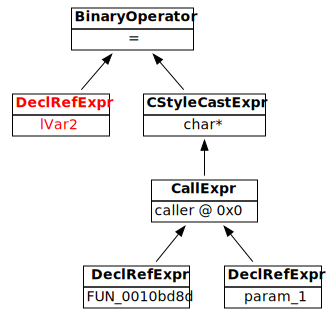

In [27]:
from astlib.color_ast import highlight_var_refs
refs[0].parent.render(format_node=highlight_var_refs(var.name))

In [28]:
# basic pattern matching attempt
# ------------------------------
# simply looking for BinOp(+)->REF
# since we know REF has been retyped to a char*, this should
# only indicate a BYTE offset
# (not a 2B, 4B, etc. offset b/c ptr arithmetic)

candidates = []
for x in refs:
    x:ASTNode
    if isinstance(x.parent, BinaryOperator):
        binop = x.parent
        if binop.opcode == '+':
            candidates.append(binop)

In [29]:
candidates

[BinaryOperator +]

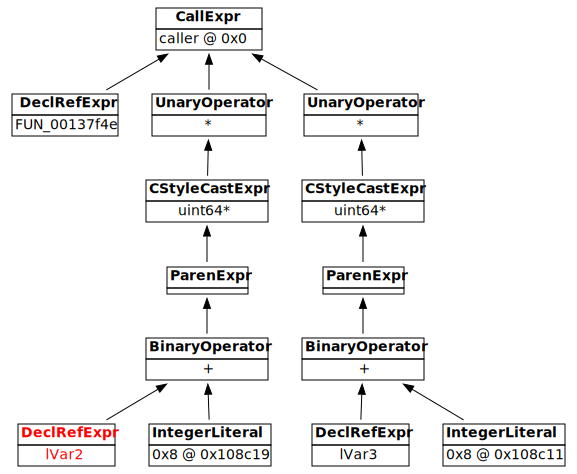

In [30]:
candidates[0].parent.parent.parent.parent.render(format_node=highlight_var_refs(var.name))

In [31]:
candidates[0].parent.parent.parent.parent.print()
ast.fdecl.print()

FUN_00137f4e(*(uint64*)(lVar2 + 8), *(uint64*)(lVar3 + 8))
uint32 FUN_00108bd9(uint64 param_1, uint64 param_2)
{
    uint32 uVar1;
    char* lVar2;
    int64 lVar3;
    lVar2 = (char*)FUN_0010bd8d(param_1);
    lVar3 = FUN_0010bd8d(param_2);
    uVar1 = FUN_00137f4e(*(uint64*)(lVar2 + 8), *(uint64*)(lVar3 + 8));
    FUN_0010b93f(lVar2);
    FUN_0010b93f(lVar3);
    return uVar1;
}



In [34]:
recovered_offsets = []
recovered_offsets.extend(filter(lambda x: isinstance(x, IntegerLiteral), candidates[0].inner))

for x in recovered_offsets:
    print(f'Recovered offset 0x{x.value:x} @ 0x{x.instr_addr:x}')

Recovered offset 0x8 @ 0x108c19


In [36]:
truth_offsets

[0, 8, 16, 24, 32, 36, 40, 41, 42, 43, 44]

In [35]:
stype.layout

0x0: uint32 uid
0x8: uchar* data
0x10: uint32 data_length
0x18: char* name
0x20: int32 chunk_start
0x24: int32 chunk_length
0x28: uchar fs
0x29: uchar filled
0x2a: uchar req
0x2b: uchar req_free
0x2c: uchar chunk

In [91]:
gcp.__exit__(None, None, None)
osgp.__exit__(None, None, None)

PROGRAM CHANGED - CHECKING IN
